## I apologize for the awful looking code 

In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [3]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [4]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result

In [5]:
def slicing(dataset, index, i):
    return dataset.slice(index).kmer_index_encoding()[i]

def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result

In [6]:
def index_to_hotshot_encoding(index_encoded_nine_mer):
    result = np.zeros((9,21))
    for position, amino_acid in enumerate(index_encoded_nine_mer):
        result[position][amino_acid]= 1
    return result.flatten()


In [8]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0


train_lr_aucs = np.zeros((folds,n_epochs))
test_lr_aucs = np.zeros((folds,n_epochs))
nine_train_lr_aucs = np.zeros((folds,n_epochs))
nine_test_lr_aucs = np.zeros((folds,n_epochs))
non_nine_train_lr_aucs = np.zeros((folds,n_epochs))
non_nine_test_lr_aucs = np.zeros((folds,n_epochs))


train_sigmoid_aucs = np.zeros((folds,n_epochs))
test_sigmoid_aucs = np.zeros((folds,n_epochs))
nine_train_sigmoid_aucs = np.zeros((folds,n_epochs))
nine_test_sigmoid_aucs = np.zeros((folds,n_epochs))
non_nine_train_sigmoid_aucs = np.zeros((folds,n_epochs))
non_nine_test_sigmoid_aucs = np.zeros((folds,n_epochs))


train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))
nine_train_nn_aucs = np.zeros((folds,n_epochs))
nine_test_nn_aucs = np.zeros((folds,n_epochs))
non_nine_train_nn_aucs = np.zeros((folds,n_epochs))
non_nine_test_nn_aucs = np.zeros((folds,n_epochs))


train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))
nine_train_lstm_aucs = np.zeros((folds,n_epochs))
nine_test_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_train_lstm_aucs = np.zeros((folds,n_epochs))
non_nine_test_lstm_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    # Linear Regression 
    lr = LinearRegression()
    
    # sigmoid
    sigmoid = Sequential()
    sigmoid.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    sigmoid.add(Flatten())
    sigmoid.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    sigmoid.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # neural net
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    
    lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # index sets
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
    # training sets
    
    
    X_train = slicing(ds_h,train_idx,0)
    y_train = label_transform(slicing(ds_h,train_idx,1))
    
    X_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_train )
    
    X_nine_train = slicing(ds_h,nine_train_idx,0)
    y_nine_train = label_transform(slicing(ds_h,nine_train_idx,1))
    
    X_nine_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_nine_train )
    
    X_non_nine_train = slicing(ds_h,non_nine_train_idx,0)
    y_non_nine_train = label_transform(slicing(ds_h,non_nine_train_idx,1))
    
    X_non_nine_train_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_non_nine_train )
    
    
    # test sets
    
    X_test = slicing(ds_h,test_idx,0)
    y_test = label_transform(slicing(ds_h,test_idx,1))
    
    X_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_test)
    
    X_nine_test = slicing(ds_h,nine_test_idx,0)
    y_nine_test = label_transform(slicing(ds_h,nine_test_idx,1))
    
    X_nine_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_nine_test)
    
    X_non_nine_test = slicing(ds_h,non_nine_test_idx,0)
    y_non_nine_test = label_transform(slicing(ds_h,non_nine_test_idx,1))
    
    X_non_nine_test_hotshot = np.apply_along_axis(index_to_hotshot_encoding,1, X_non_nine_test)
    
    # weights
    
    weights_train = slicing(ds_h,train_idx,2)
    weights_test = slicing(ds_h,test_idx,2)
    
    weights_nine_train = slicing(ds_h,nine_train_idx,2)
    weights_nine_test = slicing(ds_h,nine_test_idx,2)
    
    weights_non_nine_train = slicing(ds_h,non_nine_train_idx,2)
    weights_non_nine_test = slicing(ds_h,non_nine_test_idx,2)
    
    # original indices
    
    original_indices_train = slicing(ds_h,train_idx,3)
    original_indices_test = slicing(ds_h,test_idx,3)
    
    original_indices_nine_train = slicing(ds_h,nine_train_idx,3)
    original_indices_nine_test = slicing(ds_h,nine_test_idx,3)
    
    original_indices_non_nine_train = slicing(ds_h,non_nine_train_idx,3)
    original_indices_non_nine_test = slicing(ds_h,non_nine_test_idx,3)
    
    # real labels (to be used for AUC score calculation)
    
    train_real_labels = regroup_together(y_train, weights_train , original_indices_train)
    test_real_labels = regroup_together(y_test, weights_test , original_indices_test)
    
    nine_train_real_labels = regroup_together(y_nine_train, weights_nine_train , original_indices_nine_train)
    nine_test_real_labels = regroup_together(y_nine_test, weights_nine_test , original_indices_nine_test)
    
    non_nine_train_real_labels = regroup_together(y_non_nine_train, weights_non_nine_train , original_indices_non_nine_train)
    non_nine_test_real_labels = regroup_together(y_non_nine_test, weights_non_nine_test , original_indices_non_nine_test)
    
    # linear model 
    lr.fit(X_train_hotshot,y_train, sample_weight = weights_train)
    
    train_pred_lr = regroup_together(lr.predict(X_train_hotshot), weights_train, original_indices_train)
    test_pred_lr = regroup_together(lr.predict(X_test_hotshot), weights_test, original_indices_test)
    
    nine_train_pred_lr = regroup_together(lr.predict(X_nine_train_hotshot), weights_nine_train, original_indices_nine_train)
    nine_test_pred_lr = regroup_together(lr.predict(X_nine_test_hotshot), weights_nine_test, original_indices_nine_test)
    
    non_nine_train_pred_lr = regroup_together(lr.predict(X_non_nine_train_hotshot), weights_non_nine_train, original_indices_non_nine_train)
    non_nine_test_pred_lr = regroup_together(lr.predict(X_non_nine_test_hotshot), weights_non_nine_test, original_indices_non_nine_test)
    
    
    # AUC scores for linear model
    train_lr_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_lr)     
    test_lr_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_lr)
    
    nine_train_lr_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_lr)     
    nine_test_lr_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_lr)
    
    non_nine_train_lr_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_lr)     
    non_nine_test_lr_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_lr)
        
    
    for epoch in range(n_epochs):
        
        train_lr_aucs[i][epoch]=train_lr_auc
        test_lr_aucs[i][epoch]=test_lr_auc
        nine_train_lr_aucs[i][epoch]=nine_train_lr_auc
        nine_test_lr_aucs[i][epoch]=nine_test_lr_auc
        non_nine_train_lr_aucs[i][epoch]=non_nine_train_lr_auc
        non_nine_test_lr_aucs[i][epoch]=non_nine_test_lr_auc
        
        
        # sigmoid
        sigmoid.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_grouped_sigmoid = regroup_together(sigmoid.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)

        
        
        train_sigmoid_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped_sigmoid)     
        test_sigmoid_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped_sigmoid)
        nine_train_sigmoid_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_grouped_sigmoid)     
        nine_test_sigmoid_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_grouped_sigmoid)
        non_nine_train_sigmoid_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_grouped_sigmoid)     
        non_nine_test_sigmoid_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_grouped_sigmoid)
        
        
        train_sigmoid_aucs[i][epoch]=train_sigmoid_auc
        test_sigmoid_aucs[i][epoch]=test_sigmoid_auc
        nine_train_sigmoid_aucs[i][epoch]=nine_train_sigmoid_auc
        nine_test_sigmoid_aucs[i][epoch]=nine_test_sigmoid_auc
        non_nine_train_sigmoid_aucs[i][epoch]=non_nine_train_sigmoid_auc
        non_nine_test_sigmoid_aucs[i][epoch]=non_nine_test_sigmoid_auc
        
        
        
        # nn
        nn.fit(X_train,y_train, sample_weight = weights_train, batch_size = batch_size_nn, nb_epoch=1)
        
        train_pred_grouped = regroup_together(nn.predict(X_train), weights_train, original_indices_train)
        test_pred_grouped = regroup_together(nn.predict(X_test), weights_test, original_indices_test)
        nine_train_pred_grouped = regroup_together(nn.predict(X_nine_train), weights_nine_train, original_indices_nine_train)
        nine_test_pred_grouped = regroup_together(nn.predict(X_nine_test), weights_nine_test, original_indices_nine_test)
        non_nine_train_pred_grouped = regroup_together(nn.predict(X_non_nine_train), weights_non_nine_train, original_indices_non_nine_train)
        non_nine_test_pred_grouped = regroup_together(nn.predict(X_non_nine_test), weights_non_nine_test, original_indices_non_nine_test)

        
        
        train_nn_auc = roc_auc_score(measured_affinity_less_than(train_real_labels,500), train_pred_grouped)     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(test_real_labels,500), test_pred_grouped)
        nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(nine_train_real_labels,500), nine_train_pred_grouped)     
        nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(nine_test_real_labels,500), nine_test_pred_grouped)
        non_nine_train_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_train_real_labels,500), non_nine_train_pred_grouped)     
        non_nine_test_nn_auc = roc_auc_score(measured_affinity_less_than(non_nine_test_real_labels,500), non_nine_test_pred_grouped)
        
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        nine_train_nn_aucs[i][epoch]=nine_train_nn_auc
        nine_test_nn_aucs[i][epoch]=nine_test_nn_auc
        non_nine_train_nn_aucs[i][epoch]=non_nine_train_nn_auc
        non_nine_test_nn_aucs[i][epoch]=non_nine_test_nn_auc
        
        
        
        #lstm 
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[nine_train_idx],500),lstm.predict(X[nine_train_idx]))
        nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[nine_test_idx],500),lstm.predict(X[nine_test_idx]))
        non_nine_train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_train_idx],500),lstm.predict(X[non_nine_train_idx]))
        non_nine_test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[non_nine_test_idx],500),lstm.predict(X[non_nine_test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        nine_train_lstm_aucs[i][epoch]=nine_train_lstm_auc
        nine_test_lstm_aucs[i][epoch]=nine_test_lstm_auc
        non_nine_train_lstm_aucs[i][epoch]=non_nine_train_lstm_auc
        non_nine_test_lstm_aucs[i][epoch]=non_nine_test_lstm_auc
        
        print("All: ", test_lr_auc, test_sigmoid_auc, test_nn_auc, test_lstm_auc, epoch, i)
        print("9mer: ", nine_test_lr_auc, nine_test_sigmoid_auc, nine_test_nn_auc, nine_test_lstm_auc, epoch, i)
        print("non9mer: ", non_nine_test_lr_auc, non_nine_test_sigmoid_auc, non_nine_test_nn_auc ,non_nine_test_lstm_auc, epoch, i)
  

Epoch 1/1
22136/22136 [==============================] - 1s - loss: 0.0135     
Epoch 1/1
22136/22136 [==============================] - 2s - loss: 0.0128     
Epoch 1/1
6376/6376 [==============================] - 10s - loss: 0.0610    
All:  0.946888553477 0.944145352379 0.944826833726 0.867237522845 0 0
9mer:  0.953726137544 0.950222832206 0.95222140821 0.870168139761 0 0
non9mer:  0.931521443747 0.928436434606 0.925342161174 0.859781856811 0 0
Epoch 1/1
22136/22136 [==============================] - 1s - loss: 0.0088     
Epoch 1/1
22136/22136 [==============================] - 1s - loss: 0.0087     
Epoch 1/1
6376/6376 [==============================] - 10s - loss: 0.0488    
All:  0.946888553477 0.950665114883 0.949644029423 0.894426764623 1 0
9mer:  0.953726137544 0.958637979471 0.957669181134 0.901503784583 1 0
non9mer:  0.931521443747 0.929196106527 0.927528534018 0.876111715006 1 0
Epoch 1/1
22136/22136 [==============================] - 1s - loss: 0.0085     
Epoch 1/1
22136

In [11]:
slicing(ds_h,train_idx,0)

array([[ 0,  0,  8, ...,  7, 17, 17],
       [ 0,  0,  8, ...,  7, 17, 17],
       [ 0,  0,  8, ...,  7, 17, 17],
       ..., 
       [20, 17, 18, ..., 17,  7, 20],
       [20, 20,  8, ..., 15, 20,  4],
       [20, 20, 20, ...,  3,  2,  9]])

In [12]:
X_train

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Performance on all mers

In [9]:
train_lr_aucs_mean = np.mean(train_lr_aucs, axis=0)
test_lr_aucs_mean = np.mean(test_lr_aucs, axis=0)
train_sigmoid_aucs_mean = np.mean(train_sigmoid_aucs, axis=0)
test_sigmoid_aucs_mean = np.mean(test_sigmoid_aucs, axis=0)
train_nn_aucs_mean = np.mean(train_nn_aucs, axis=0)
test_nn_aucs_mean = np.mean(test_nn_aucs, axis=0)
train_lstm_aucs_mean=np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

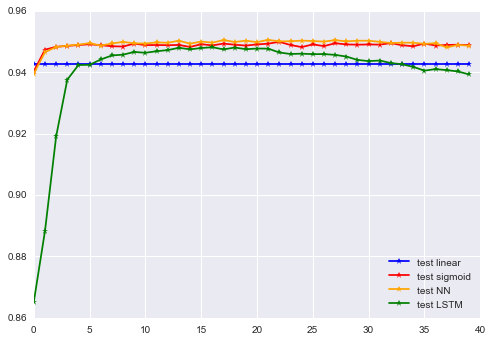

In [14]:
plt.plot( np.arange(0,40,1), test_lr_aucs_mean[0:40],color='b',marker='*', linestyle='-', label ="test linear")
plt.plot( np.arange(0,40,1), test_sigmoid_aucs_mean[0:40],color='r',marker='*', linestyle='-', label ="test sigmoid")
plt.plot( np.arange(0,40,1), test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN")
plt.plot( np.arange(0,40,1), test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM")

plt.legend(loc=4)

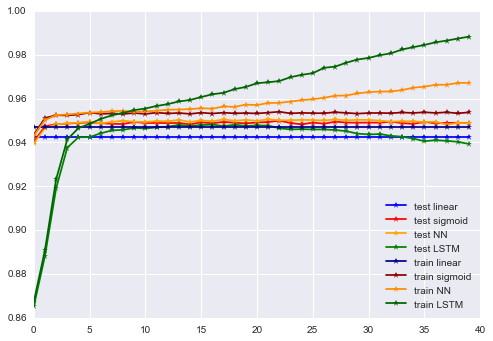

In [24]:
plt.plot( np.arange(0,40,1), test_lr_aucs_mean[0:40],color='b',marker='*', linestyle='-', label ="test linear")
plt.plot( np.arange(0,40,1), test_sigmoid_aucs_mean[0:40],color='r',marker='*', linestyle='-', label ="test sigmoid")
plt.plot( np.arange(0,40,1), test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN")
plt.plot( np.arange(0,40,1), test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM")

plt.plot( np.arange(0,40,1), train_lr_aucs_mean[0:40],color='darkblue',marker='*', linestyle='-', label ="train linear")
plt.plot( np.arange(0,40,1), train_sigmoid_aucs_mean[0:40],color='darkred',marker='*', linestyle='-', label ="train sigmoid")
plt.plot( np.arange(0,40,1), train_nn_aucs_mean[0:40],color='darkorange',marker='*', linestyle='-', label ="train NN")
plt.plot( np.arange(0,40,1), train_lstm_aucs_mean[0:40],color='darkgreen',marker='*', linestyle='-', label ="train LSTM")

plt.legend(loc=4)

## Performance on 9 mers

In [15]:
nine_train_lr_aucs_mean = np.mean(nine_train_lr_aucs, axis=0)
nine_test_lr_aucs_mean = np.mean(nine_test_lr_aucs, axis=0)
nine_train_sigmoid_aucs_mean = np.mean(nine_train_sigmoid_aucs, axis=0)
nine_test_sigmoid_aucs_mean = np.mean(nine_test_sigmoid_aucs, axis=0)
nine_train_nn_aucs_mean = np.mean(nine_train_nn_aucs, axis=0)
nine_test_nn_aucs_mean = np.mean(nine_test_nn_aucs, axis=0)
nine_train_lstm_aucs_mean=np.mean(nine_train_lstm_aucs, axis=0)
nine_test_lstm_aucs_mean = np.mean(nine_test_lstm_aucs, axis=0)

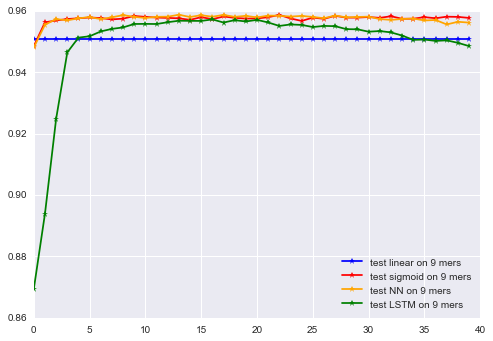

In [17]:
plt.plot( np.arange(0,40,1), nine_test_lr_aucs_mean[0:40],color='b',marker='*', linestyle='-', label ="test linear on 9 mers")
plt.plot( np.arange(0,40,1), nine_test_sigmoid_aucs_mean[0:40],color='r',marker='*', linestyle='-', label ="test sigmoid on 9 mers")
plt.plot( np.arange(0,40,1), nine_test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN on 9 mers")
plt.plot( np.arange(0,40,1), nine_test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM on 9 mers")
plt.legend(loc=4)

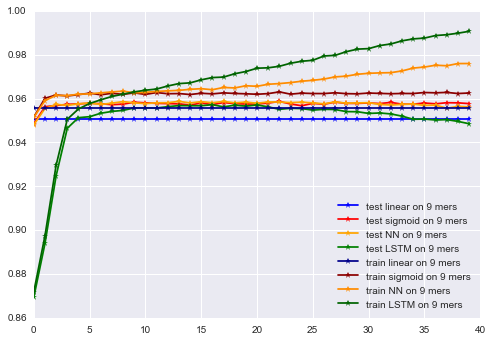

In [25]:
plt.plot( np.arange(0,40,1), nine_test_lr_aucs_mean[0:40],color='b',marker='*', linestyle='-', label ="test linear on 9 mers")
plt.plot( np.arange(0,40,1), nine_test_sigmoid_aucs_mean[0:40],color='r',marker='*', linestyle='-', label ="test sigmoid on 9 mers")
plt.plot( np.arange(0,40,1), nine_test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN on 9 mers")
plt.plot( np.arange(0,40,1), nine_test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM on 9 mers")

plt.plot( np.arange(0,40,1), nine_train_lr_aucs_mean[0:40],color='darkblue',marker='*', linestyle='-', label ="train linear on 9 mers")
plt.plot( np.arange(0,40,1), nine_train_sigmoid_aucs_mean[0:40],color='darkred',marker='*', linestyle='-', label ="train sigmoid on 9 mers")
plt.plot( np.arange(0,40,1), nine_train_nn_aucs_mean[0:40],color='darkorange',marker='*', linestyle='-', label ="train NN on 9 mers")
plt.plot( np.arange(0,40,1), nine_train_lstm_aucs_mean[0:40],color='darkgreen',marker='*', linestyle='-', label ="train LSTM on 9 mers")
plt.legend(loc=4)

## Performance on non - 9 mers

In [19]:
non_nine_train_lr_aucs_mean = np.mean(non_nine_train_lr_aucs, axis=0)
non_nine_test_lr_aucs_mean = np.mean(non_nine_test_lr_aucs, axis=0)
non_nine_train_sigmoid_aucs_mean = np.mean(non_nine_train_sigmoid_aucs, axis=0)
non_nine_test_sigmoid_aucs_mean = np.mean(non_nine_test_sigmoid_aucs, axis=0)
non_nine_train_nn_aucs_mean = np.mean(non_nine_train_nn_aucs, axis=0)
non_nine_test_nn_aucs_mean = np.mean(non_nine_test_nn_aucs, axis=0)
non_nine_train_lstm_aucs_mean=np.mean(non_nine_train_lstm_aucs, axis=0)


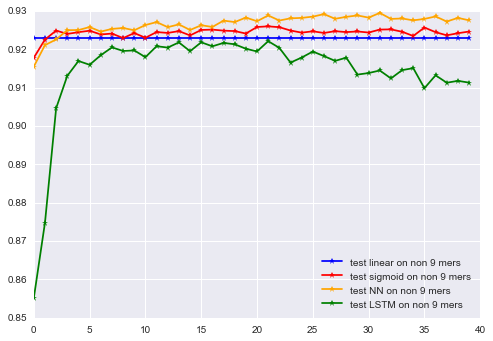

In [20]:
plt.plot( np.arange(0,40,1), non_nine_test_lr_aucs_mean[0:40],color='b',marker='*', linestyle='-', label ="test linear on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_test_sigmoid_aucs_mean[0:40],color='r',marker='*', linestyle='-', label ="test sigmoid on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM on non 9 mers")
plt.legend(loc=4)

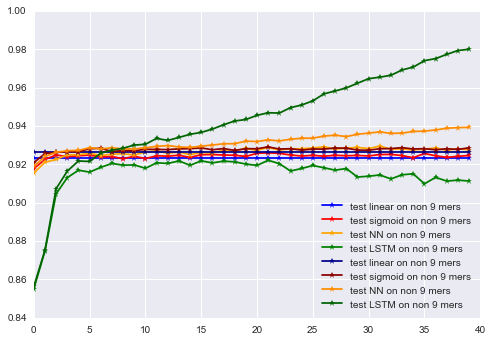

In [23]:
plt.plot( np.arange(0,40,1), non_nine_test_lr_aucs_mean[0:40],color='b',marker='*', linestyle='-', label ="test linear on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_test_sigmoid_aucs_mean[0:40],color='r',marker='*', linestyle='-', label ="test sigmoid on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM on non 9 mers")

plt.plot( np.arange(0,40,1), non_nine_train_lr_aucs_mean[0:40],color='darkblue',marker='*', linestyle='-', label ="train linear on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_train_sigmoid_aucs_mean[0:40],color='darkred',marker='*', linestyle='-', label ="train sigmoid on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_train_nn_aucs_mean[0:40],color='darkorange',marker='*', linestyle='-', label ="train NN on non 9 mers")
plt.plot( np.arange(0,40,1), non_nine_train_lstm_aucs_mean[0:40],color='darkgreen',marker='*', linestyle='-', label ="train LSTM on non 9 mers")

plt.legend(loc=4)